# Local Minecraft Benchmark Analysis

This notebook analyzes the performance metrics collected from your local Minecraft benchmark using the same visualization techniques as the Yardstick example.

The local benchmark generates JSON-formatted metrics from Telegraf, which we'll process and visualize to understand:
- CPU utilization over time
- Memory usage patterns  
- JVM performance metrics
- System load characteristics

## Import Required Libraries

Import the necessary libraries for data processing and visualization.

In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from datetime import datetime

# Set up plotting style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load and Process Benchmark Data

Load the JSON metrics data from your local benchmark results.

In [2]:
# Specify the path to your benchmark results
# Update this path to point to your specific benchmark run
benchmark_path = Path("local_benchmark_results/minecraft_benchmark_20250611_234147")
metrics_file = benchmark_path / "metrics.json"

print(f"Looking for metrics in: {metrics_file}")
print(f"File exists: {metrics_file.exists()}")

if not metrics_file.exists():
    # Find the most recent benchmark automatically
    benchmark_dirs = list(Path("local_benchmark_results").glob("minecraft_benchmark_*"))
    if benchmark_dirs:
        benchmark_path = max(benchmark_dirs, key=lambda x: x.name)
        metrics_file = benchmark_path / "metrics.json"
        print(f"Using most recent benchmark: {benchmark_path}")
    else:
        print("No benchmark directories found!")
        print("Please run the local_minecraft_benchmark.py script first.")

Looking for metrics in: local_benchmark_results/minecraft_benchmark_20250611_234147/metrics.json
File exists: True


In [4]:
def load_metrics_from_json(metrics_file):
    """Load and parse JSON metrics from Telegraf output."""
    metrics = []
    
    with open(metrics_file, 'r') as f:
        for line in f:
            try:
                metric = json.loads(line.strip())
                metrics.append(metric)
            except json.JSONDecodeError:
                continue  # Skip malformed lines
    
    return metrics

def metrics_to_dataframe(metrics, metric_name):
    """Convert specific metric type to pandas DataFrame."""
    filtered_metrics = [m for m in metrics if m.get('name') == metric_name]
    
    if not filtered_metrics:
        return pd.DataFrame()
    
    rows = []
    for metric in filtered_metrics:
        row = {
            'timestamp': metric['timestamp'],
            'host': metric.get('tags', {}).get('host', 'unknown')
        }
        
        # Add all fields as columns
        for field, value in metric.get('fields', {}).items():
            row[field] = value
            
        # Add relevant tags as columns
        for tag, value in metric.get('tags', {}).items():
            if tag != 'host':  # Already added host
                row[f'tag_{tag}'] = value
                
        rows.append(row)
    
    df = pd.DataFrame(rows)
    if not df.empty:
        # Convert timestamp to relative time in minutes
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp_m'] = df['timestamp'] / 60
    
    return df

# Load the metrics
if metrics_file.exists():
    print("Loading metrics data...")
    all_metrics = load_metrics_from_json(metrics_file)
    print(f"Loaded {len(all_metrics)} metric records")
    
    # Get unique metric types
    metric_types = set(m.get('name') for m in all_metrics)
    print(f"Available metric types: {sorted(metric_types)}")
else:
    print("Metrics file not found!")

Loading metrics data...
Loaded 3058 metric records
Available metric types: ['cpu', 'disk', 'diskio', 'jvm_garbage_collector', 'jvm_memory', 'mem', 'minecraft_tick_times', 'processes', 'system']


## CPU Utilization Analysis

Analyze and visualize CPU utilization patterns during the benchmark.

CPU data shape: (746, 14)
CPU data columns: ['timestamp', 'host', 'usage_guest', 'usage_guest_nice', 'usage_idle', 'usage_iowait', 'usage_irq', 'usage_nice', 'usage_softirq', 'usage_steal', 'usage_system', 'usage_user', 'tag_cpu', 'timestamp_m']


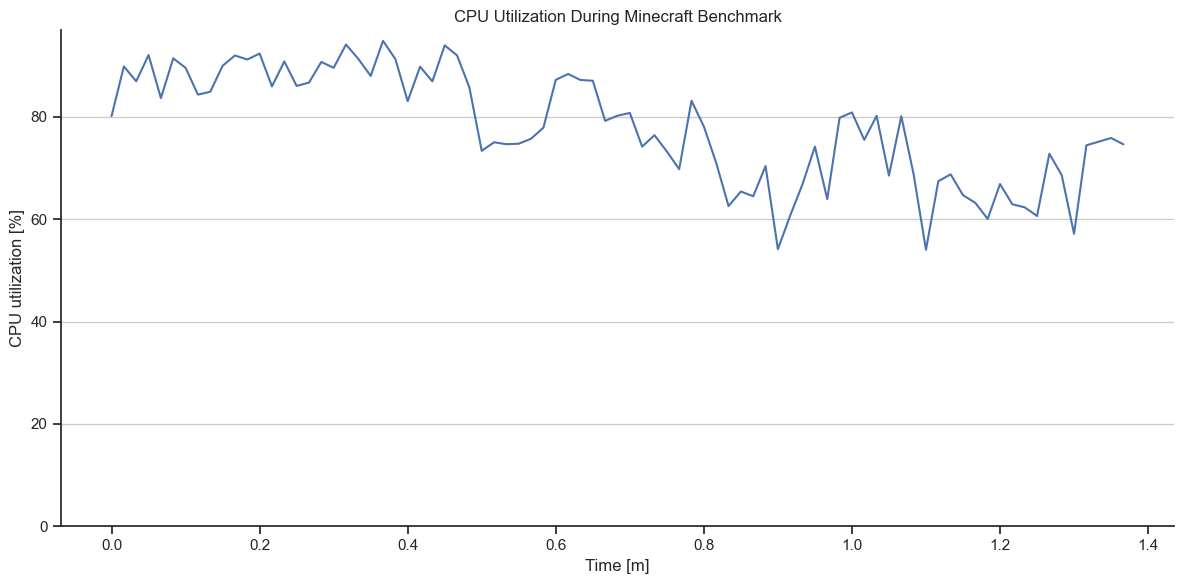

Average CPU utilization: 78.14%
Peak CPU utilization: 94.85%


In [5]:
# Process CPU metrics
if 'cpu' in metric_types:
    cpu_df = metrics_to_dataframe(all_metrics, 'cpu')
    
    if not cpu_df.empty:
        print(f"CPU data shape: {cpu_df.shape}")
        print(f"CPU data columns: {list(cpu_df.columns)}")
        
        # Filter for total CPU only (if available)
        if 'tag_cpu' in cpu_df.columns:
            total_cpu_df = cpu_df[cpu_df['tag_cpu'] == 'cpu-total'].copy()
        else:
            total_cpu_df = cpu_df.copy()
        
        if not total_cpu_df.empty:
            # Calculate CPU utilization percentage
            # The JSON format might use different field names than CSV
            if 'usage_user' in total_cpu_df.columns and 'usage_system' in total_cpu_df.columns:
                # Telegraf percentage format
                total_cpu_df['cpu_util'] = total_cpu_df['usage_user'] + total_cpu_df['usage_system']
            elif 'time_user' in total_cpu_df.columns and 'time_system' in total_cpu_df.columns:
                # Calculate from time values
                total_cpu_df['time_active'] = (total_cpu_df['time_user'] + 
                                             total_cpu_df['time_system'] + 
                                             total_cpu_df.get('time_nice', 0))
                total_cpu_df['time_total'] = total_cpu_df['time_active'] + total_cpu_df.get('time_idle', 0)
                total_cpu_df['cpu_util'] = 100 * total_cpu_df['time_active'] / total_cpu_df['time_total']
            else:
                print("Available CPU columns:", list(total_cpu_df.columns))
                # Use any available percentage column
                pct_cols = [col for col in total_cpu_df.columns if 'percent' in col.lower() or 'usage' in col.lower()]
                if pct_cols:
                    total_cpu_df['cpu_util'] = total_cpu_df[pct_cols[0]]
                    print(f"Using {pct_cols[0]} for CPU utilization")
            
            # Create CPU utilization plot
            if 'cpu_util' in total_cpu_df.columns:
                plt.figure(figsize=(12, 6))
                ax = sns.lineplot(data=total_cpu_df, x="timestamp_m", y="cpu_util")
                ax.grid(axis="y")
                ax.set_ylim(bottom=0)
                ax.set_ylabel("CPU utilization [%]")
                ax.set_xlabel("Time [m]")
                ax.set_title("CPU Utilization During Minecraft Benchmark")
                plt.tight_layout()
                plt.show()
                
                # Print statistics
                print(f"Average CPU utilization: {total_cpu_df['cpu_util'].mean():.2f}%")
                print(f"Peak CPU utilization: {total_cpu_df['cpu_util'].max():.2f}%")
            else:
                print("Could not determine CPU utilization metric")
                print("First few rows of CPU data:")
                print(total_cpu_df.head())
        else:
            print("No total CPU data found")
    else:
        print("No CPU data available")
else:
    print("No CPU metrics found in the data")

## Memory Usage Analysis

Analyze memory usage patterns during the benchmark.

Memory data shape: (84, 12)
Memory data columns: ['timestamp', 'host', 'active', 'available', 'available_percent', 'free', 'inactive', 'total', 'used', 'used_percent', 'wired', 'timestamp_m']


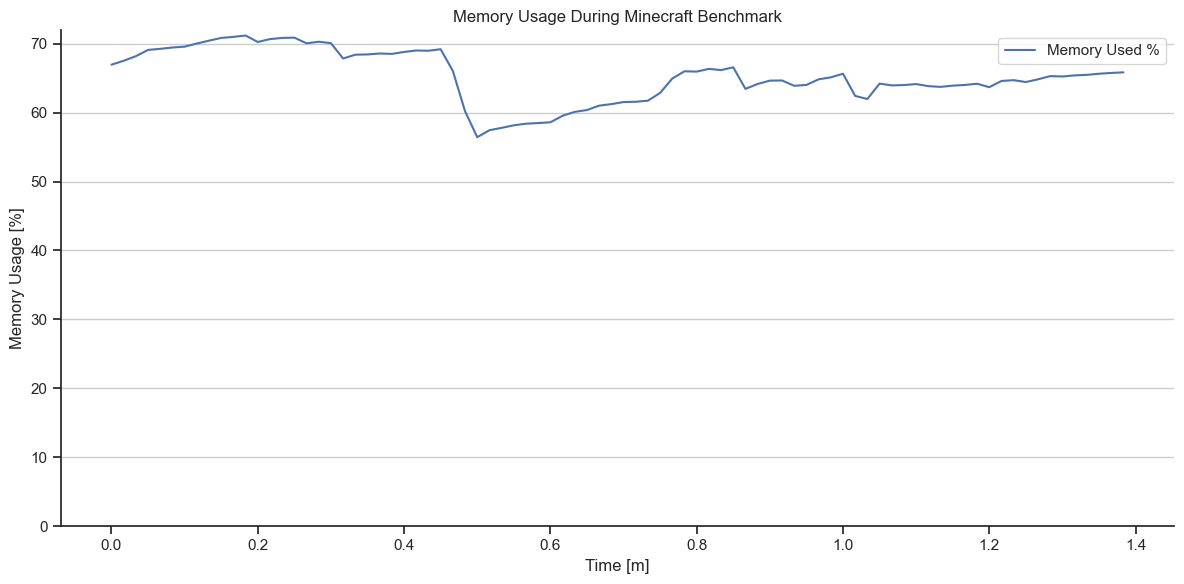

Average memory usage: 65.27%
Peak memory usage: 71.18%
Memory used (MB): 10694 MB average


In [6]:
# Process Memory metrics
if 'mem' in metric_types:
    mem_df = metrics_to_dataframe(all_metrics, 'mem')
    
    if not mem_df.empty:
        print(f"Memory data shape: {mem_df.shape}")
        print(f"Memory data columns: {list(mem_df.columns)}")
        
        # Create memory usage plot
        plt.figure(figsize=(12, 6))
        
        if 'used_percent' in mem_df.columns:
            ax = sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", label="Memory Used %")
            ax.set_ylabel("Memory Usage [%]")
        elif 'used' in mem_df.columns and 'total' in mem_df.columns:
            mem_df['used_percent'] = 100 * mem_df['used'] / mem_df['total']
            ax = sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", label="Memory Used %")
            ax.set_ylabel("Memory Usage [%]")
        
        ax.grid(axis="y")
        ax.set_ylim(bottom=0)
        ax.set_xlabel("Time [m]")
        ax.set_title("Memory Usage During Minecraft Benchmark")
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        if 'used_percent' in mem_df.columns:
            print(f"Average memory usage: {mem_df['used_percent'].mean():.2f}%")
            print(f"Peak memory usage: {mem_df['used_percent'].max():.2f}%")
            
        if 'used' in mem_df.columns:
            print(f"Memory used (MB): {mem_df['used'].mean() / (1024*1024):.0f} MB average")
    else:
        print("No memory data available")
else:
    print("No memory metrics found in the data")

## System Load Analysis

Analyze system load during the benchmark.

System data shape: (252, 11)
System data columns: ['timestamp', 'host', 'load1', 'load15', 'load5', 'n_cpus', 'n_unique_users', 'n_users', 'uptime', 'uptime_format', 'timestamp_m']


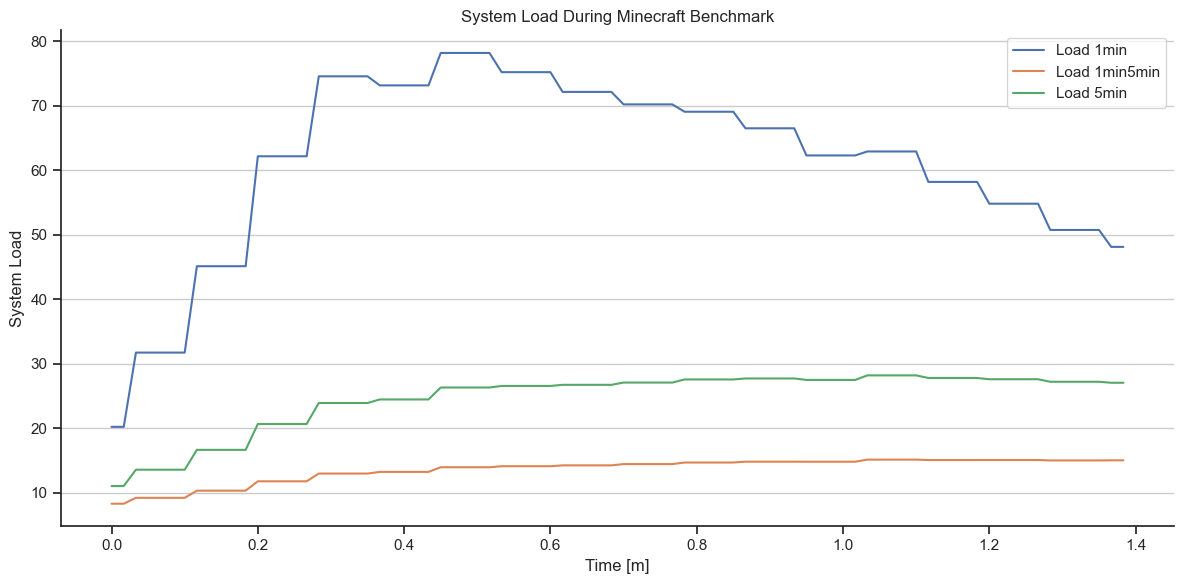

Average 1-min load: 61.58
Peak 1-min load: 78.20


In [7]:
# Process System metrics
if 'system' in metric_types:
    system_df = metrics_to_dataframe(all_metrics, 'system')
    
    if not system_df.empty:
        print(f"System data shape: {system_df.shape}")
        print(f"System data columns: {list(system_df.columns)}")
        
        # Create system load plot
        load_cols = [col for col in system_df.columns if col.startswith('load')]
        if load_cols:
            plt.figure(figsize=(12, 6))
            
            for col in load_cols:
                if col in system_df.columns:
                    label = col.replace('load', 'Load ').replace('1', '1min').replace('5', '5min').replace('15', '15min')
                    sns.lineplot(data=system_df, x="timestamp_m", y=col, label=label)
            
            plt.grid(axis="y")
            plt.ylabel("System Load")
            plt.xlabel("Time [m]")
            plt.title("System Load During Minecraft Benchmark")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            if 'load1' in system_df.columns:
                print(f"Average 1-min load: {system_df['load1'].mean():.2f}")
                print(f"Peak 1-min load: {system_df['load1'].max():.2f}")
        else:
            print("No load metrics found in system data")
    else:
        print("No system data available")
else:
    print("No system metrics found in the data")

## JVM Memory Analysis (If Available)

Analyze JVM memory usage from Jolokia if the data is available.

In [ ]:
# Look for JVM metrics
jvm_metrics = [metric_name for metric_name in metric_types if 'jvm' in metric_name.lower()]
print(f"Available JVM metrics: {jvm_metrics}")

if jvm_metrics:
    for jvm_metric in jvm_metrics:
        jvm_df = metrics_to_dataframe(all_metrics, jvm_metric)
        
        if not jvm_df.empty:
            print(f"\n{jvm_metric} data shape: {jvm_df.shape}")
            print(f"{jvm_metric} data columns: {list(jvm_df.columns)}")
            
            # Look for memory-related columns
            memory_cols = [col for col in jvm_df.columns if 'memory' in col.lower() or 'heap' in col.lower()]
            if memory_cols:
                plt.figure(figsize=(12, 6))
                
                for col in memory_cols[:3]:  # Limit to first 3 to avoid overcrowding
                    if jvm_df[col].dtype in ['int64', 'float64']:
                        # Convert bytes to MB if values are large
                        if jvm_df[col].max() > 1000000:
                            jvm_df[f'{col}_mb'] = jvm_df[col] / (1024 * 1024)
                            sns.lineplot(data=jvm_df, x="timestamp_m", y=f'{col}_mb', label=f"{col} (MB)")
                        else:
                            sns.lineplot(data=jvm_df, x="timestamp_m", y=col, label=col)
                
                plt.grid(axis="y")
                plt.ylabel("Memory Usage")
                plt.xlabel("Time [m]")
                plt.title(f"JVM {jvm_metric.title()} During Minecraft Benchmark")
                plt.legend()
                plt.tight_layout()
                plt.show()
else:
    print("No JVM metrics found. This might be because:")
    print("1. The Jolokia agent wasn't properly connected")
    print("2. The Minecraft server didn't expose JMX metrics")
    print("3. The metrics collection period was too short")

## Summary Dashboard

Create a combined dashboard showing key metrics.

In [ ]:
# Create a summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Minecraft Benchmark Summary Dashboard', fontsize=16)

# CPU plot
if 'cpu' in metric_types:
    cpu_df = metrics_to_dataframe(all_metrics, 'cpu')
    if not cpu_df.empty and 'tag_cpu' in cpu_df.columns:
        total_cpu_df = cpu_df[cpu_df['tag_cpu'] == 'cpu-total'].copy()
        if 'usage_user' in total_cpu_df.columns:
            total_cpu_df['cpu_util'] = total_cpu_df['usage_user'] + total_cpu_df.get('usage_system', 0)
            sns.lineplot(data=total_cpu_df, x="timestamp_m", y="cpu_util", ax=axes[0,0])
            axes[0,0].set_title('CPU Utilization')
            axes[0,0].set_ylabel('CPU [%]')
            axes[0,0].grid(True)

# Memory plot  
if 'mem' in metric_types:
    mem_df = metrics_to_dataframe(all_metrics, 'mem')
    if not mem_df.empty and 'used_percent' in mem_df.columns:
        sns.lineplot(data=mem_df, x="timestamp_m", y="used_percent", ax=axes[0,1])
        axes[0,1].set_title('Memory Usage')
        axes[0,1].set_ylabel('Memory [%]')
        axes[0,1].grid(True)

# System load plot
if 'system' in metric_types:
    system_df = metrics_to_dataframe(all_metrics, 'system')
    if not system_df.empty and 'load1' in system_df.columns:
        sns.lineplot(data=system_df, x="timestamp_m", y="load1", ax=axes[1,0])
        axes[1,0].set_title('System Load (1min)')
        axes[1,0].set_ylabel('Load')
        axes[1,0].grid(True)

# Disk I/O plot
if 'diskio' in metric_types:
    diskio_df = metrics_to_dataframe(all_metrics, 'diskio')
    if not diskio_df.empty:
        # Sum up total read/write bytes across all disks
        if 'read_bytes' in diskio_df.columns and 'write_bytes' in diskio_df.columns:
            disk_summary = diskio_df.groupby('timestamp_m').agg({
                'read_bytes': 'sum',
                'write_bytes': 'sum'
            }).reset_index()
            
            sns.lineplot(data=disk_summary, x="timestamp_m", y="read_bytes", ax=axes[1,1], label="Read")
            sns.lineplot(data=disk_summary, x="timestamp_m", y="write_bytes", ax=axes[1,1], label="Write")
            axes[1,1].set_title('Disk I/O')
            axes[1,1].set_ylabel('Bytes')
            axes[1,1].grid(True)
            axes[1,1].legend()

# Set common x-axis labels
for ax in axes.flat:
    ax.set_xlabel('Time [m]')

plt.tight_layout()
plt.show()

# Print benchmark summary
print("\n" + "="*50)
print("BENCHMARK SUMMARY")
print("="*50)
print(f"Benchmark directory: {benchmark_path}")
print(f"Total metrics collected: {len(all_metrics)}")
print(f"Metric types: {sorted(metric_types)}")

if all_metrics:
    duration = (max(m['timestamp'] for m in all_metrics) - min(m['timestamp'] for m in all_metrics)) / 60
    print(f"Benchmark duration: {duration:.1f} minutes")

## Export Processed Data

Export the processed data to CSV format for further analysis or comparison with Yardstick results.

In [ ]:
# Export processed metrics to CSV files for further analysis
output_dir = benchmark_path / "processed_csv"
output_dir.mkdir(exist_ok=True)

print(f"Exporting processed data to: {output_dir}")

exported_files = []

for metric_name in metric_types:
    df = metrics_to_dataframe(all_metrics, metric_name)
    if not df.empty:
        output_file = output_dir / f"{metric_name}.csv"
        df.to_csv(output_file, index=False)
        exported_files.append(output_file)
        print(f"Exported {metric_name}: {len(df)} records -> {output_file}")

print(f"\nExported {len(exported_files)} CSV files:")
for file in exported_files:
    print(f"  {file}")

print(f"\nYou can now use these CSV files with the original Yardstick analysis code!")